
# PET TOF listmode projector

In [1]:

import os
# import array_api_compat.numpy as xp
import array_api_compat.cupy as xp
# import array_api_compat.torch as xp
import parallelproj
from array_api_compat import to_device
import array_api_compat.numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.io import loadmat


# choose a device (CPU or CUDA GPU)
if "numpy" in xp.__name__:
    # using numpy, device must be cpu
    dev = "cpu"
elif "cupy" in xp.__name__:
    # using cupy, only cuda devices are possible
    dev = xp.cuda.Device(0)
elif "torch" in xp.__name__:
    # using torch valid choices are 'cpu' or 'cuda'
    dev = "cuda"


          -  -  -  -  -  -  -  -   -  -  -  -
          P  A  R  A  L  L  E  L | P  R  O  J
          -  -  -  -  -  -  -  -   -  -  -  -


         Please consider citing our publication
      ---------------------------------------------
      Georg Schramm and Kris Thielemans:
      "PARALLELPROJ—an open-source framework for
       fast calculation of projections in
       tomography"
      Front. Nucl. Med., 08 January 2024
      Sec. PET and SPECT, Vol 3
      https://doi.org/10.3389/fnume.2023.1324562

 
    parallelproj C    lib: /home/pablo/anaconda3/envs/deep-scatter-attenuation-PET/lib/libparallelproj_c.so.1.8.0
    parallelproj CUDA lib: /home/pablo/anaconda3/envs/deep-scatter-attenuation-PET/lib/libparallelproj_cuda.so.1.8.0
    


setup a regular polygon PET scanner



In [2]:
# # Create a Quadra PET scanner
# num_rings = 320
# radius = 410.0  #mm
# max_z = 530.0
# ### create a reduced Quadra PET scanner
# original_max_z = max_z
# max_z = 240.0
# num_rings = int(num_rings * max_z / original_max_z)
# ###


# Create a Vision PET scanner
radius = 410.0  #mm
num_rings = 80
max_z = 131.15
num_sides = 760
scanner = parallelproj.RegularPolygonPETScannerGeometry(
    xp,
    dev,
    radius=radius,
    num_sides=num_sides,
    num_lor_endpoints_per_side=1,
    lor_spacing=0.0,
    ring_positions=xp.linspace(-max_z, max_z, num_rings),
    symmetry_axis=1,
)

# Image parameters
img_shape = (248, 140, 176)  # for head and neck
voxel_size = (1.9531, 1.9531, 1.5)  # for head and neck

# TOF
TOF_resolution = 225
tofbin_FWHM = TOF_resolution * 1e-12 * 3e8 / 2 *1e3 # *1e3 to mm;  *1e-12 to s; *3e8 to m/s;  /2 to get one-way distance;
sigma_tof = tofbin_FWHM / 2.355 # to get sigma from FWHM
tofbin_width = sigma_tof * 1.03  # sigma_tof * 1.03, as given in https://parallelproj.readthedocs.io/en/stable/python_api.html#module-parallelproj.tof # ps, it is the minimum time difference between the arrival of two photons that it can detect. it is diveded by 2 because if one of them arrivs TOF_resolution


In [3]:
import pandas as pd
import struct

# Define the structure format for one data record
format_string = 'Q f i f f f f f f h h'
record_size = struct.calcsize(format_string)

# Define the dtype for numpy based on the format string
dtype = np.dtype([
    ('emission_time', 'u8'), # unsigned long long int (Q) (emission_time (ps))
    ('travel_time', 'f4'),   # float (f) (travel_time (ps))
    ('emission_voxel', 'i4'),# int (i) (emission voxel)
    ('energy', 'f4'),        # float (f) (energy)
    ('z', 'f4'),             # float (f) (z (cm))
    ('phi', 'f4'),           # float (f) (phi (rad))
    ('vx', 'f4'),            # float (f) (vx; x component of the incident photon direction)
    ('vy', 'f4'),            # float (f) (vy; y component of the incident photon direction)
    ('vz', 'f4'),            # float (f) (vz; z component of the incident photon direction)
    ('index1', 'i2'),        # short int (h)  Flag for scatter: =0 for non-scattered, =1 for Compton, =2 for Rayleigh, and =3 for multiple scatter)
    ('index2', 'i2')         # short int (h) (index2)
])

# Read the binary file in chunks and convert directly to DataFrame
chunk_size = 100000 

# Define the path to your binary .raw file
psf_path = '/home/pablo/prototwin/deep-learning-dose-activity-dictionary/pet-simulation-reconstruction/mcgpu-pet/washout_curve/experiment_1/MCGPU_PET.psf.raw'
events = []
with open(psf_path, 'rb') as file:
    while True:
        data = file.read(record_size * chunk_size)
        if not data:
            break
        
        chunk = np.frombuffer(data, dtype=dtype)
        
        event = pd.DataFrame(chunk).loc[:, ['emission_voxel', 'emission_time', 'travel_time','z', 'phi', 'vx', 'vy', 'vz']]
        events.append(event)

events = pd.concat(events, ignore_index=True)

In [4]:
num_events = events.shape[0]
travel_time = xp.asarray(events.travel_time)
vx = xp.asarray(events.vx)
vy = xp.asarray(events.vy)
vz = xp.asarray(events.vz)
phi = xp.asarray(events.phi)
events_x = radius * xp.cos(phi)
events_y = radius * xp.sin(phi)
events_z = xp.asarray(events.z)
emission_time = xp.asarray(events.emission_time)
emission_voxel = xp.asarray(events.emission_voxel)

# 1. DOI effect
# Accounting for the angle of incidence of the photon, larger DOI if incidence angle is larger
# We are getting the length of the path inside the detectors of each photon, solving:
# r_salida (posicion donde sale del scanner) = r_vec (posicion donde llega al scanner) + v (direccion incidente) * DOI (escalar); sqrt(r_salida(0)**2 + r_salida(1)**2) = R+20mm (radio del escaner + anchura del cristal, ya que sale en el borde del cristal)
depth = 20  #mm depth of crystal (depth is the max DOI if all photons are incident perpendicular to the crystal)
max_dois = 1 / (vx**2 + vy**2) * (-(vx * events_x + vy * events_y) + xp.sqrt((vx * events_x + vy * events_y)**2 - (vx**2 + vy**2) * (events_x**2 + events_y**2 - (radius + depth)**2)))
del events

mu = 0.082 # mm^-1 attenuation coefficient
uniform_rands = xp.random.uniform(0, 1, num_events)  # one sample per event

# Cumulative distribution function capturing that the probability of 
# a photon being detected is higher when photons enter the crystal 
# and decreases exponentially as they move into the crystal, considering a maximum depth of d and normalizing
# F(x) = 1 - exp(-mu*x) / (1 - exp(-mu*max_doi))
# Then, inverse transform sampling to sample values from the distribution
# Sampling from this inverse function means picking random probabilities and finding the points on the distribution that correspond to those probabilities
# (inverse of the CDF: F^-1(u) = -ln(1 - u(1 - exp(-mu*d))) / mu;

dois = -np.log(1 - uniform_rands * (1 - xp.exp(-mu * max_dois))) / mu
del uniform_rands

# 2. Detector resolution effect:
# The detector resolution is modeled as a Gaussian distribution with a FWHM of 3.39 mm
# Values are sampled from a normal distribution with FWHM = 3.39 mm and added to the x, y, and z coordinates of the events
FWHM_detector= 3.39  # mm (given by detector side length, 2*pi*radius/num_sides)
sigma_detector = FWHM_detector / 2.355
mean = 0.0
event_displacement = xp.random.normal(mean, sigma_detector, num_events * 3)

events_x = events_x + event_displacement[:num_events] + vx * dois  # x position of the detector
events_y = events_y + event_displacement[num_events:2*num_events] + vy * dois  # y position of the detector
events_z = events_z * 10.0 + event_displacement[2*num_events:3*num_events] + vz * dois   # *10.0 for cm to mm

# 3. Crystal size effects:
# the angle and z position of the event are rounded to the position of the crystal
crystal_phi_positions = xp.linspace(0, 2 * xp.pi, num_sides, endpoint=False) - np.pi
events_phi = xp.arctan2(events_y, events_x)  # angle of the event once DOI and detector resolution are considered
events_phi[events_phi > xp.pi - 2*xp.pi/num_sides] -= 2*xp.pi  # wrap around, so that if it wont be assigned to the bin below when it should be assigned to phi=-pi
events_phi = xp.digitize(events_phi, crystal_phi_positions) * 2 * xp.pi / num_sides - xp.pi  # round to the closest crystal phi position
events_x = radius * xp.cos(events_phi)  # x position of the crystal corresponding to the event
events_y = radius * xp.sin(events_phi)  # y position of the crystal corresponding to the event

crystal_z_positions = xp.linspace(-max_z, max_z, num_rings)
events_z = xp.digitize(xp.asarray(events_z), crystal_z_positions) * 2 * max_z / num_rings - max_z  # round to the closest crystal z position

bin = xp.round((travel_time[0::2] - travel_time[1::2]) / (TOF_resolution / 2.355 * 1.03)).astype(int)  # / 2.355 * 1.03 to match the spatial tof_bin width
bin = xp.repeat(bin, 2)

# If outputting scatters, remove events with index1 != 0 and their corresponding antiparallel events (row above if uneven index1, row below if even index1)
# events['photon_pairs'] = events.index // 2
# scattered_pairs = events[events['index1'] != 0]['photon_pairs'].unique()
# events = events[~events['photon_pairs'].isin(scattered_pairs)]
# events = events.drop(columns='photon_pairs')

event_start_coordinates = xp.asarray(xp.stack((events_x[0::2], events_y[0::2], events_z[0::2]), axis=1))
event_end_coordinates = xp.asarray(xp.stack((events_x[1::2], events_y[1::2], events_z[1::2]), axis=1))

event_tof_bins = bin[0::2]
# num_tofbins = xp.max(xp.abs(event_tof_bins)) * 2 + 1
num_tofbins = 51
if num_tofbins % 2 == 0:
    num_tofbins -= 1
print("num_tofbins", num_tofbins)

tof_params = parallelproj.TOFParameters(
    sigma_tof=sigma_tof, num_tofbins=num_tofbins, tofbin_width=tofbin_width
)

# # count unique values
# unique, counts = np.unique(bin, return_counts=True)
# print(dict(zip(unique, counts)))


num_tofbins 51


-243.669666226406 242.2194156089977


Text(0.5, 1.0, 'Tumor Volume')

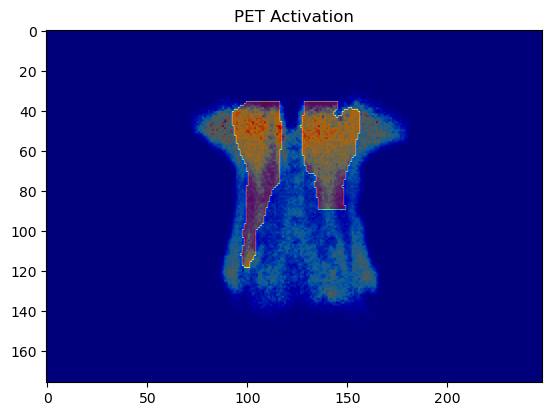

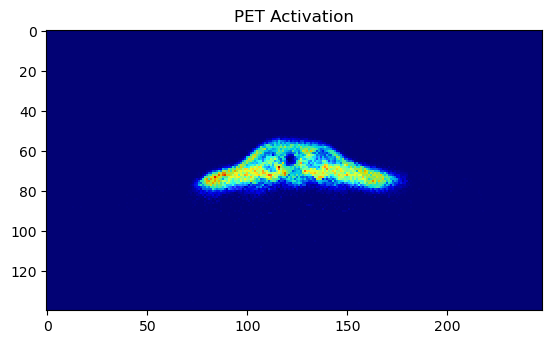

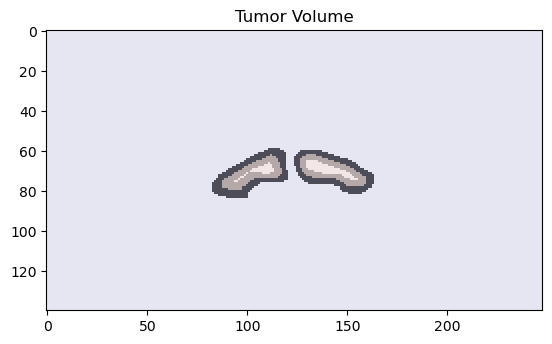

In [5]:
from scipy.ndimage import binary_erosion, binary_dilation

# ACTIVATION FROM EVENT LIST
time_diff = travel_time[0::2] - travel_time[1::2]  # ps, measured time difference between the two photon arrivals
# time_diff += xp.random.normal(0, TOF_resolution/2.355, time_diff.shape)  # adding noise according to the TOF resolution

distance_detections = xp.linalg.norm(event_start_coordinates - event_end_coordinates, axis=1)  # mm, distance between the crystals where the two photon where detected
# Position of the event: middle of LOR + distance traveled
event_position = (event_start_coordinates + event_end_coordinates) / 2  + 1000 * 3e8 * time_diff[:, xp.newaxis] / 1e12 * (event_end_coordinates - event_start_coordinates) / distance_detections[:, xp.newaxis] / 2  # mm  # * 1000 to convert m to mm; * 3e8 to convert s to m; / 1e12 to convert ps to s; / 2 to get the middle of the LOR
grid_center = (xp.array(img_shape) * xp.array(voxel_size)) / 2

print(event_position.min(), event_position.max())
event_indices = xp.round((event_position + grid_center)/xp.array(voxel_size)).astype(int)
event_1d_indices = xp.ravel_multi_index(event_indices.T, img_shape)

# event_1d_indices = xp.array(emission_voxel[::2])###
event_counts = xp.bincount(xp.asarray(event_1d_indices, device=dev), minlength=xp.prod(xp.array(img_shape)))
pet_activation = event_counts.reshape(img_shape)###, order="F")
pet_activation_arr = pet_activation.get()
adjoint_ones = np.load('/home/pablo/prototwin/deep-learning-dose-activity-dictionary/pet-simulation-reconstruction/mcgpu-pet/sensitivity_head_simulation/image_Trues.npy')
pet_activation_arr = pet_activation_arr / adjoint_ones.astype(np.int16)
pet_activation_normalized = (pet_activation_arr - pet_activation_arr.min()) / (pet_activation_arr.max() - pet_activation_arr.min())

# Loading the tumor volume
uncropped_shape = (272, 272, 176)
patient_folder = '/home/pablo/HeadPlans/HN-CHUM-018'  # Folder with the patient's treatment plan
matRad_output = loadmat(os.path.join(patient_folder, 'matRad-output.mat'))
cst = matRad_output['cst']
tumor_indices = cst[32, 3][0][0].T[0]  #Gross Tumor Volume indices, taken from cst in matrad (/home/pablo/matRad-master/matRad_head_protons.m)
tumor_indices -= 1  # 0-based indexing, from MATLAB to Pytho
tumor_coords = xp.unravel_index(xp.array(tumor_indices), [uncropped_shape[2], uncropped_shape[1], uncropped_shape[0]])  # Convert to multi-dimensional formtumor_coords = (tumor_coords[1], tumor_coords[2], tumor_coords[0])  # Adjusting from MATLAB to Python
tumor_coords = (tumor_coords[1], tumor_coords[2], tumor_coords[0])  # Adjusting from MATLAB to Python
tumor_volume = xp.zeros(uncropped_shape)
tumor_volume[tumor_coords] = 1
xmin, xmax = 12, -12  # Crops in each dimension to remove empty areas
ymin, ymax = 27, -105
tumor_volume = tumor_volume[xmin:xmax, ymin:ymax, :]
# Eroded tumor (necrosis)

erosion_size = np.round(np.array([1, 1, 1]) / (np.array(voxel_size) / 10)).astype(int)  # 1 cm^3
structure = np.ones(tuple(erosion_size)) # Define the structure for erosion (1x1x1cm cube), divided by voxel size to get the number of eroded voxels
eroded_tumor = binary_erosion(tumor_volume.get(), structure=structure)
eroded_pixels_mask = tumor_volume.get() - eroded_tumor
dilated_tumor = binary_dilation(tumor_volume.get(), structure=structure)
dilated_pixels_mask = dilated_tumor - tumor_volume.get()

# GROUND TRUTH ACTIVATION
dtype = xp.float32
activation = xp.load('/home/pablo/prototwin/deep-learning-dose-activity-dictionary/pet-simulation-reconstruction/mcgpu-pet/washout_curve/phantom_activity.npy')
activation = xp.asarray(activation, dtype=dtype)
activation = to_device(activation, dev)
activation_arr = activation.get()
activation_normalized = (activation_arr - activation_arr.min()) / (activation_arr.max() - activation_arr.min())

y_slice = activation.shape[1] // 2
plt.figure()
plt.imshow(activation_normalized[:, y_slice, :].T,alpha=0.9, cmap="Greys")
plt.imshow(pet_activation_normalized[:, y_slice, :].T, alpha=0.9, cmap="jet")
plt.imshow(tumor_volume.get()[:, y_slice, :].T, alpha=0.6, cmap="jet")
plt.title("PET Activation")

z_slice = activation.shape[2] // 2 - 30
plt.figure()
plt.imshow(activation_normalized[:, :, z_slice].T,alpha=0.9, cmap="Greys")
plt.imshow(pet_activation_normalized[:, :, z_slice].T, alpha=0.9, cmap="jet")
plt.title("PET Activation")

plt.figure()
plt.imshow(tumor_volume.get()[:, :, z_slice].T, alpha=0.6, cmap="jet")
plt.imshow(eroded_pixels_mask[:, :, z_slice].T, alpha=0.6, cmap="Greys")
plt.imshow(dilated_pixels_mask[:, :, z_slice].T, alpha=0.6, cmap="Greys")
plt.title("Tumor Volume")



# del events_phi, radius, event_displacement, dois, travel_time, vx, vy, vz, emission_voxel


[0.0009098016559832676, 0.0011111111111111111]
[1.19199651e-06 1.73322570e-06]


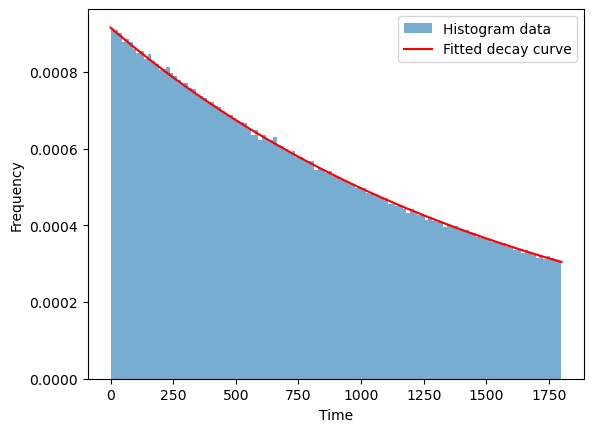

Fitted parameters: a = 0.0009153913133979794, b = 0.0006114751788410041
Mean life: τ = 1635.3893577420586


In [6]:
# Decay curve inside the tumor
### tumor_volume = volume; tumor_volume = xp.asarray(dilated_pixels_mask, device=dev)
tumor_indices = xp.argwhere(tumor_volume == 1)
tumor_1d_indices = xp.ravel_multi_index(tumor_indices.T, img_shape)

data = xp.array(emission_time[::2] * 1e-12)  # ps to s
events_in_tumor = xp.in1d(event_1d_indices, tumor_1d_indices)
data = data[events_in_tumor]

n_bins = 100###00
time = xp.linspace(0, 1800, n_bins)
hist, _ = xp.histogram(data, bins=n_bins, density=True)
# Define the exponential decay function
def decay_function(x, a, b):
    return a * np.exp(-b * x )

initial_guesses = [hist.max().get().item(), 1 / time.mean().get()]
print(initial_guesses)
params, cov = curve_fit(decay_function, time.get(), hist.get(), p0=initial_guesses)
std = np.sqrt(np.diag(cov))
print(std)
params_lower = params - 2 * std  # Uncertainty in the fit
params_upper = params + 2 * std


# Calculate the mean life
mean_life = 1 / params[1]
# params[1] = 1 / 2000

# Plot the histogram and the fitted decay curve
plt.figure()
plt.hist(data.get(), bins='auto', density=True, alpha=0.6, label='Histogram data')
plt.plot(time.get(), decay_function(time.get(), *params), 'r-', label='Fitted decay curve')
plt.fill_between(time.get(), decay_function(time.get(), *params_lower), decay_function(time.get(), *params_upper), color='r', alpha=0.2)
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# Print fitted parameters and mean life
print(f'Fitted parameters: a = {params[0]}, b = {params[1]}')
print(f'Mean life: τ = {mean_life}')

# 1663 for non tumor, 663.25 for tumor

x_idx  0
x_idx  10
x_idx  20
x_idx  30
x_idx  40
x_idx  50
x_idx  60
x_idx  70
x_idx  80
x_idx  90
x_idx  100
x_idx  110
x_idx  120
x_idx  130
x_idx  140
x_idx  150
x_idx  160
x_idx  170
x_idx  180
x_idx  190
x_idx  200
x_idx  210
x_idx  220
x_idx  230
x_idx  240


Text(0.5, 1.0, 'Decay map')

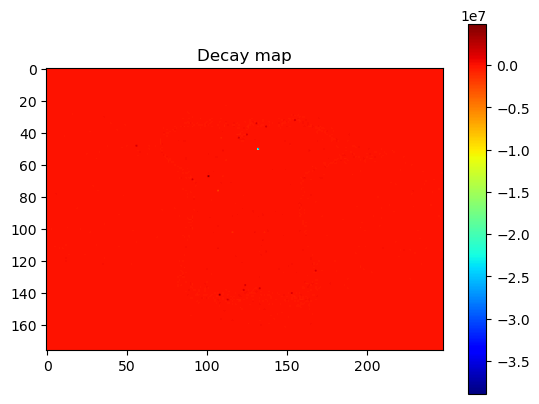

In [7]:
# Plotting a map of the decay curve for y_slice

decay_map = xp.zeros(img_shape)
# Define the exponential decay function
def decay_function(x, a, b):
    return a * np.exp(-b * x)
n_bins = 10000
time = xp.linspace(0, 1800, n_bins)
data = xp.array(emission_time[::2] * 1e-12)  # ps to s

idx_3d = xp.array([0, y_slice, 0])
for x_idx in range(img_shape[0]):
    for z_idx in range(img_shape[2]):
        idx_3d[0] = x_idx
        idx_3d[2] = z_idx
        raveled_idx = xp.ravel_multi_index(idx_3d, img_shape)
        if x_idx % 10 == 0 and z_idx == 0:
            print("x_idx ", x_idx)
        data_idx = data[xp.where(event_1d_indices == raveled_idx)]
        if data_idx.size == 0:
            continue
        hist, _ = xp.histogram(data_idx, bins=n_bins, density=True)
        initial_guesses = [hist.max().get().item(), 1 / time.mean().get()]
        try:
            params, _ = curve_fit(decay_function, time.get(), hist.get(), p0=initial_guesses)
            mean_life = 1 / params[1]
        except RuntimeError:
            mean_life = 0
        # assign mean_life to idx in array
        decay_map.ravel()[raveled_idx] = mean_life
    
decay_map = decay_map.get()

# Plot the map
plt.figure()
plt.imshow(decay_map[:, y_slice, :].T, cmap='jet')
# add colorbar
plt.colorbar()
plt.title('Decay map')

# 1000 for non tumor, 663.25 for tumor

Text(0.5, 1.0, 'Decay map')

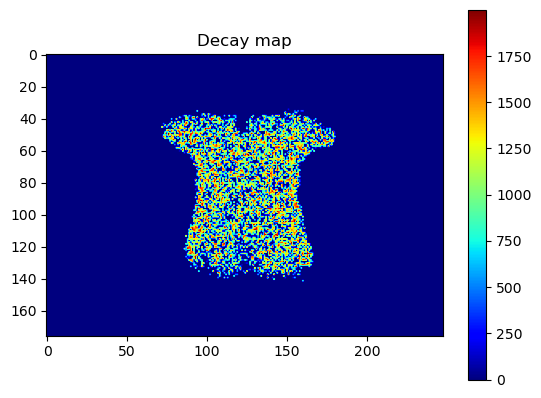

In [8]:
from cupyx.scipy.ndimage import median_filter
cropped_decay_map = decay_map.copy()
cropped_decay_map[cropped_decay_map > 2000] = 0
cropped_decay_map[cropped_decay_map < 0] = 0
# Plot the map
plt.figure()
plt.imshow(cropped_decay_map[:, y_slice, :].T, cmap='jet')
# add colorbar
plt.colorbar()
plt.title('Decay map')


## Show the scanner geometry and the events



In [9]:
# fig = plt.figure(figsize=(8, 8))
# ax = fig.add_subplot(111, projection="3d")
# scanner.show_lor_endpoints(ax)
# for i in range(event_start_coordinates.shape[0]):
#     ax.plot(
#         [float(event_start_coordinates[i, 0]), float(event_end_coordinates[i, 0])],
#         [float(event_start_coordinates[i, 2]), float(event_end_coordinates[i, 2])],
#         [float(event_start_coordinates[i, 1]), float(event_end_coordinates[i, 1])],
#     )
#     print(event_start_coordinates[i], event_end_coordinates[i])
#     if i == 2:
#         break

# ax.view_init(elev=0, azim=90)
# fig.tight_layout()


## Setup a TOF listmode projector


In [10]:
# lor_desc = parallelproj.RegularPolygonPETLORDescriptor(
#     scanner,
#     radial_trim=1,
#     max_ring_difference=85,
#     span=19,  ##11
#     sinogram_order=parallelproj.SinogramSpatialAxisOrder.RVP,
# )

# # Can comment out anything related to proj if importing sensitivity
# proj = parallelproj.RegularPolygonPETProjector(
#     lor_desc, img_shape=img_shape, voxel_size=voxel_size
# )

enable_tof = True
# if enable_tof:
#     proj.tof_parameters = tof_params


res_model = parallelproj.GaussianFilterOperator(
    img_shape, sigma=3.5 / (2.35 * xp.asarray(voxel_size))  # PSF: related to detector crystal size, positron range, no colinearity
)

# compose all 3 operators into a single linear operator
# pet_lin_op = parallelproj.CompositeLinearOperator((att_op, proj, res_model))
# pet_lin_op = parallelproj.CompositeLinearOperator((proj, res_model))

# print(pet_lin_op.out_shape)

# Best option: Importing sensitivity for the CT instead of finding adjoint_ones
# import gzip 
# file_path = '/home/pablo/prototwin/deep-learning-dose-activity-dictionary/pet-simulation-reconstruction/mcgpu-pet/sensitivity_head_simulation/image_Trues.raw.gz'
# with gzip.open(file_path, 'rb') as f:
#     adjoint_ones = xp.frombuffer(f.read(), dtype=np.int32).reshape(img_shape, order='F')
# adjoint_ones[adjoint_ones==0] = 1  # to avoid dividing by zero, only happens at the edge of FOV
# np.save('/home/pablo/prototwin/deep-learning-dose-activity-dictionary/pet-simulation-reconstruction/mcgpu-pet/sensitivity_head_simulation/image_Trues.npy', adjoint_ones)
adjoint_ones = np.load('/home/pablo/prototwin/deep-learning-dose-activity-dictionary/pet-simulation-reconstruction/mcgpu-pet/sensitivity_head_simulation/image_Trues.npy')

# # Slower option: finding adjoint_ones for the sensitivity
# adjoint_ones = pet_lin_op.adjoint(
#     xp.ones(pet_lin_op.out_shape, dtype=xp.float32, device=dev)  
# )


In [11]:
# # Let's see how adjoint_ones looks like
# adjoint_ones = adjoint_ones == 0
# plt.imshow(adjoint_ones[:,21,:].get(), cmap='jet')
# plt.colorbar()
# print(adjoint_ones.min(), adjoint_ones.mean(), adjoint_ones.max())

In [12]:
lm_proj = parallelproj.ListmodePETProjector(
    event_start_coordinates, event_end_coordinates, img_shape, voxel_size
)

if enable_tof:
    lm_proj.tof_parameters = tof_params
    lm_proj.event_tofbins = event_tof_bins
    lm_proj.tof = enable_tof

print(f"proj output shape {lm_proj.out_shape}")

proj output shape (9632003,)


In [13]:
num_subsets = 1
subset_slices = [slice(i, None, num_subsets) for i in range(num_subsets)]

lm_pet_subset_linop_seq = []

for i, sl in enumerate(subset_slices):
    subset_lm_proj = parallelproj.ListmodePETProjector(
        event_start_coordinates[sl, :], event_end_coordinates[sl, :], img_shape, voxel_size
    )

    # enable TOF in the LM projector
    subset_lm_proj.tof_parameters = lm_proj.tof_parameters
    if lm_proj.tof:
        # we need to make a copy of the 1D subset event_tofbins array
        # stupid way of doing this, but torch asarray copy doesn't seem to work
        subset_lm_proj.event_tofbins = 1 * event_tof_bins[sl]
        subset_lm_proj.tof = lm_proj.tof

    # lm_pet_subset_linop_seq.append(
    #     subset_lm_proj
    # )
    lm_pet_subset_linop_seq.append(
        parallelproj.CompositeLinearOperator(
            # (subset_lm_att_op, subset_lm_proj, res_model)
            (subset_lm_proj, res_model)
        )
    )

lm_pet_subset_linop_seq = parallelproj.LinearOperatorSequence(lm_pet_subset_linop_seq)


In [14]:
def lm_em_update(x_cur, op, adjoint_ones):
    """LM EM update

    Parameters
    ----------
    x_cur : Array
        current solution
    op : parallelproj.LinearOperator
        subset listmode linear forward operator
    adjoint_ones : Array
        adjoint of ones of the non-LM (the complete) operator
        divided by the number of subsets

    Returns
    -------
    Array
        _description_
    """
    epsilon = 1e-10  #  If ybar contains zeros, dividing by it can produce NaNs
    ybar = op(x_cur)
    x = x_cur * op.adjoint(1 / (ybar + epsilon)) / adjoint_ones
    # x = (1-beta)*x + beta*medianfilter(x)  # one step late regularization
    return x

In [15]:
import array_api_compat.torch as torch
import torch.nn.functional as F
# from scipy.ndimage import median_filter
import cupy as cp
from cupyx.scipy.ndimage import median_filter
import math

# regularized mlem: https://downloads.hindawi.com/journals/mpe/2014/491239.pdf?_gl=1*qw2bn9*_ga*MTkxNDI0Mzc1MC4xNzE2NTY0Nzg2*_ga_NF5QFMJT5V*MTcxNjU2NDc4NS4xLjAuMTcxNjU2NDc4NS42MC4wLjA.&_ga=2.3863920.199569902.1716564786-1914243750.1716564786
def g(x, K):
    sqrt_5K = (5 ** 0.5) * K
    result = torch.zeros_like(x)
    mask = torch.abs(x) <= sqrt_5K
    result[mask] = (25 / (16 * K)) * (1 - (x[mask] / sqrt_5K) ** 2) ** 2
    return result

def mlem_pde_update(x_cur, op, adjoint_ones, w=1.0, K="MAD", kernel_size=3):
    epsilon = 1e-10  #  If ybar contains zeros, dividing by it can produce NaNs
    ybar = op(x_cur)
    x = x_cur * op.adjoint(1 / (ybar + epsilon)) / adjoint_ones
    
    x = torch.tensor(x, device='cuda').unsqueeze(0)
    pad = kernel_size // 2
    x_padded = F.pad(x.unsqueeze(0), (pad, pad, pad, pad, pad, pad), mode='replicate').squeeze(1)
    # Unfolding to extract the neighbours in each dimension
    x_unfolded = x_padded.unfold(1, kernel_size, 1).unfold(2, kernel_size, 1).unfold(3, kernel_size, 1)  # 5 for the first dim because it is in length of 1 mm
    x_unfolded = x_unfolded.flatten(start_dim=1, end_dim=3).flatten(start_dim=2, end_dim=4).squeeze(0)  # flattening the spatial dimensions

    # finding the values in the target vector larger than a certain threshold wrt the max
    x_flat = x.flatten(start_dim=1, end_dim=3).squeeze(0).unsqueeze(-1)
    grad_f = x_flat - x_unfolded
    if K == "MAD":
        K = 1.4826 * torch.median(torch.abs(grad_f - torch.median(grad_f)))  # Black et al., https://en.wikipedia.org/wiki/Median_absolute_deviation
    elif K == "MEAN":
        K = torch.mean(torch.abs(grad_f))  # Torkamani-Azar and Tait
    # K = 1.5  # given in the paper
    reg_term = 1 / (kernel_size ** len(img_shape)) * torch.sum(g(torch.abs(grad_f), K) * grad_f, dim=1).reshape(img_shape)
    x = x + reg_term * w
    x = xp.asarray(x.squeeze(0), device=dev)   
    x = median_filter(x, size=kernel_size)
    return x

In [16]:
# test_img_shape = (4, 4, 4)###

# # Make a 4d array of values going from 1 to size(x)
# x = torch.arange(math.prod(test_img_shape)).reshape(test_img_shape).unsqueeze(0).type(torch.float32)
# x_padded = F.pad(x.unsqueeze(1), (1, 1, 1, 1, 1, 1), mode='replicate').squeeze(1)
# # Unfolding to extract the neighbours in each dimension
# x_unfolded = x_padded.unfold(1, kernel_size, 1).unfold(2, kernel_size, 1).unfold(3, kernel_size, 1)  # 5 for the first dim because it is in length of 1 mm
# x_unfolded = x_unfolded.flatten(start_dim=1, end_dim=3).flatten(start_dim=2, end_dim=4).squeeze(0)  # flattening the spatial dimensions

# # finding the values in the target vector larger than a certain threshold wrt the max
# x_flat = x.flatten(start_dim=1, end_dim=3).squeeze(0).unsqueeze(-1)
# grad_f = x_flat - x_unfolded
# w = 1.0
# # K = torch.mean(torch.abs(grad_f))  # Torkamani-Azar and Tait
# K = 1.5  # given in the paper
# # K = 1.4826 * torch.median(torch.abs(grad_f - torch.median(grad_f)))  # Black et al., https://en.wikipedia.org/wiki/Median_absolute_deviation

# # print(x_flat.shape, x_unfolded.shape)
# # print((x_flat - x_unfolded).shape)
# # print((x_flat - x_unfolded)[21])
# # print(torch.sum(g(torch.abs(grad_f), K) * grad_f, dim=1).reshape(img_shape).shape)

# reg_term = w / (kernel_size ** len(img_shape)) * torch.sum(g(torch.abs(grad_f), K) * grad_f, dim=1).reshape(img_shape)

# print(median_filter(reg_term, size=3).shape)


In [17]:
# number of MLEM iterations
num_iter = 4

from cupyx.scipy.ndimage import median_filter###

x = xp.ones(img_shape, dtype=xp.float32, device=dev)
adjoint_ones = to_device(xp.asarray(adjoint_ones, dtype=xp.float32), dev)

x_list = []
# w = 0.5  ###
for i in range(num_iter):
    for k, sl in enumerate(subset_slices):
        print(f"OSEM iteration {(k+1):03} / {(i + 1):03} / {num_iter:03}", end="\r")
        # w = w * 0.5 ###
        x = lm_em_update(
        # x = mlem_pde_update(
            x,
            lm_pet_subset_linop_seq[k],
            adjoint_ones / num_subsets,
            # w=w, K=1.5, kernel_size = 3
        )
        x_list.append(x.get())
        

0.0 0.01 60720.188
(248, 140, 176) 0 302 15951368


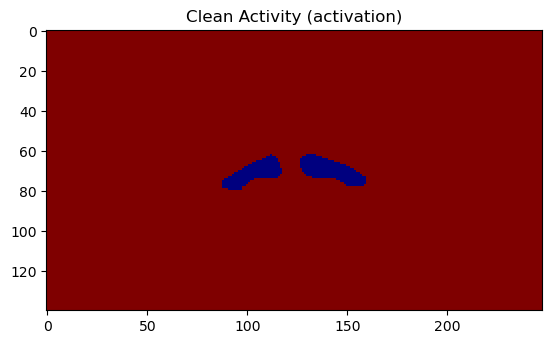

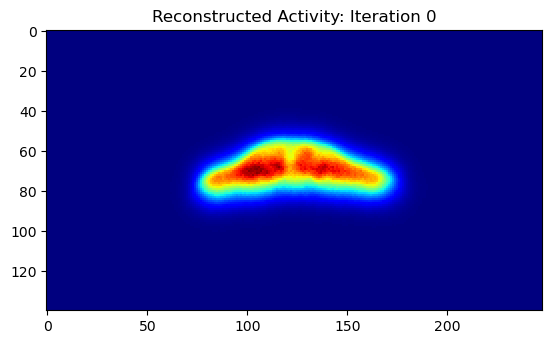

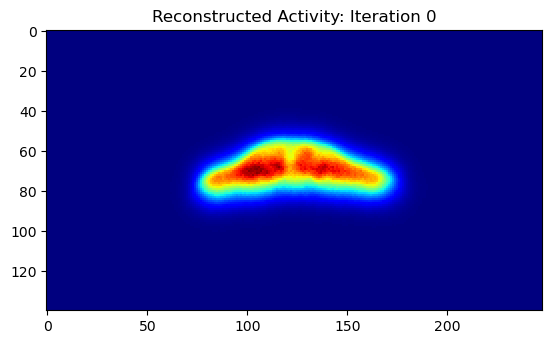

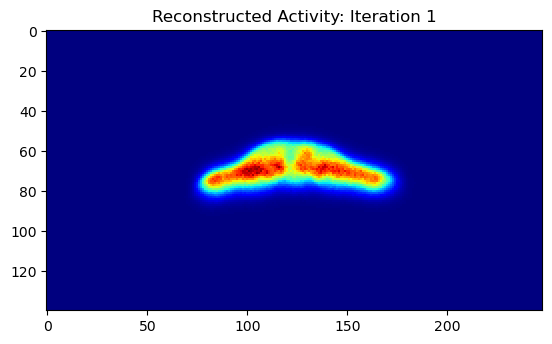

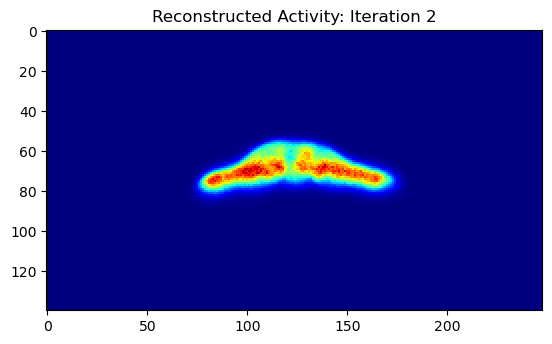

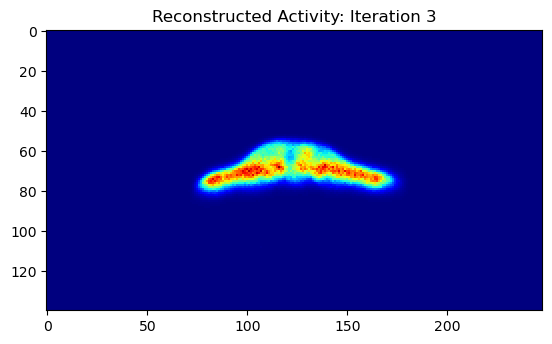

In [18]:
import os
dtype = np.float32
# npy_location = os.path.join(f"/home/pablo/prototwin/deep-learning-dose-activity-dictionary/data/head-sobp-dataset{dataset_num}/activation_uncropped")
# activation = np.load(npy_location + "/sobp0.npy")
dataset_num = 3

activation = np.load('/home/pablo/prototwin/deep-learning-dose-activity-dictionary/pet-simulation-reconstruction/mcgpu-pet/washout_curve/phantom_activity.npy')
# activation = activation.astype(int)
activation = xp.asarray(activation, dtype=dtype)
activation = to_device(activation, dev)
print(activation.min(), activation.max(), activation.sum())

# Open .raw.gz file
import gzip
with gzip.open("/home/pablo/prototwin/deep-learning-dose-activity-dictionary/pet-simulation-reconstruction/mcgpu-pet/vision_head_simulation/image_Trues.raw.gz", 'rb') as f:
    activation_trues = xp.frombuffer(f.read(), dtype=np.int32).reshape(img_shape, order='F')
print(activation_trues.shape, activation_trues.min(), activation_trues.max(), activation_trues.sum())


# Plot the activity image above and the x image below
z_slice = activation.shape[2] // 2 - 30

activation_arr = activation.get()
activation_normalized = (activation_arr - activation_arr.min()) / (activation_arr.max() - activation_arr.min())

plt.figure()
plt.imshow(activation_normalized[:, :, z_slice].T, cmap="jet")
plt.title("Clean Activity (activation)")

num_plots = 5

for iter in np.linspace(0, len(x_list) - 1, num_plots, dtype=int):
    x_normalized = (x_list[iter] - x_list[iter].min()) / (x_list[iter].max() - x_list[iter].min())
    plt.figure()
    plt.imshow(x_normalized[:, :, z_slice].T, cmap="jet")
    plt.title(f"Reconstructed Activity: Iteration {iter}")   

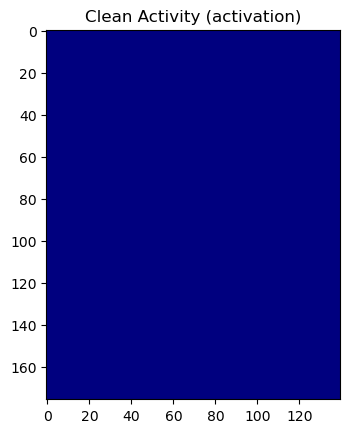

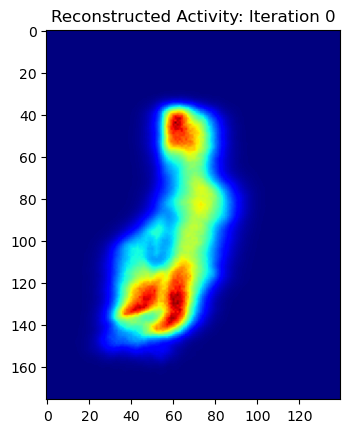

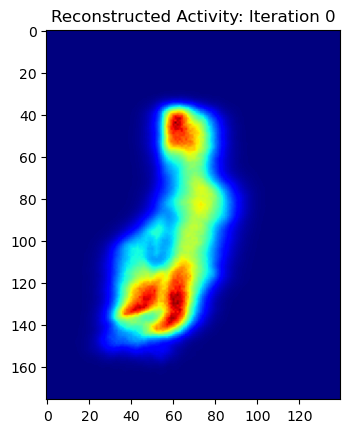

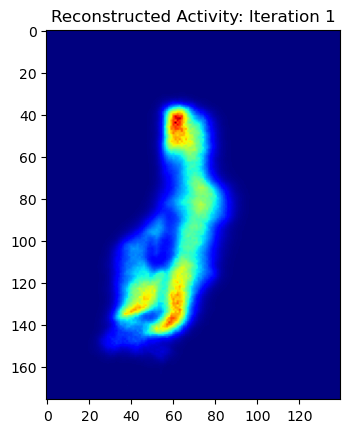

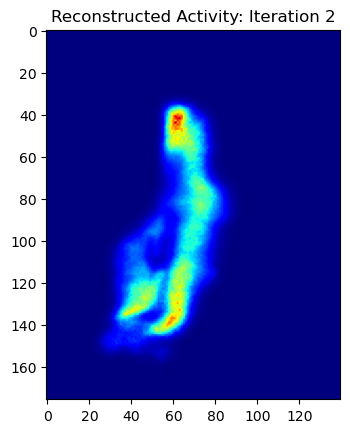

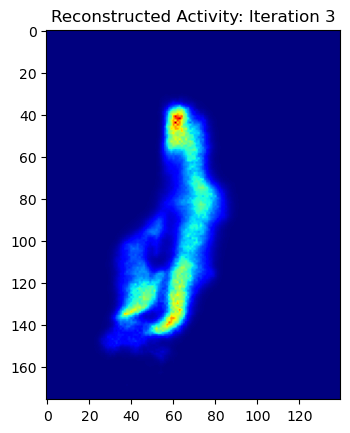

In [19]:
x_slice = activation.shape[0] // 2

plt.figure()
plt.imshow(activation_normalized[x_slice, :, :].T, cmap="jet")
plt.title("Clean Activity (activation)")

num_plots = 5

for iter in np.linspace(0, len(x_list) - 1, num_plots, dtype=int):
    x_normalized = (x_list[iter] - x_list[iter].min()) / (x_list[iter].max() - x_list[iter].min())
    plt.figure()
    plt.imshow(x_normalized[x_slice, :, :].T, cmap="jet")
    plt.title(f"Reconstructed Activity: Iteration {iter}")   

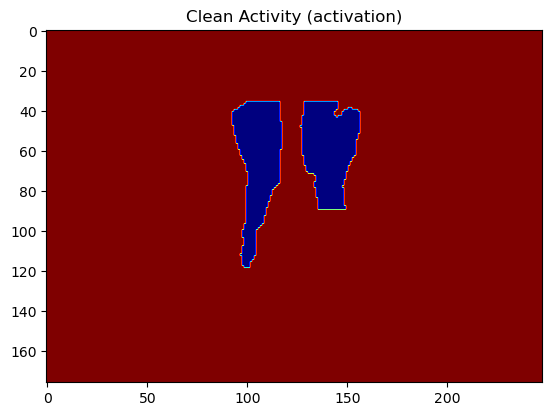

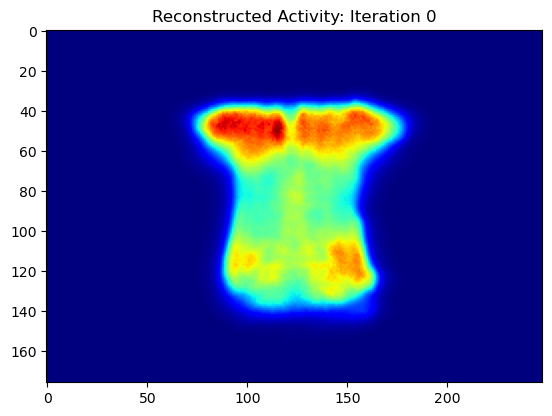

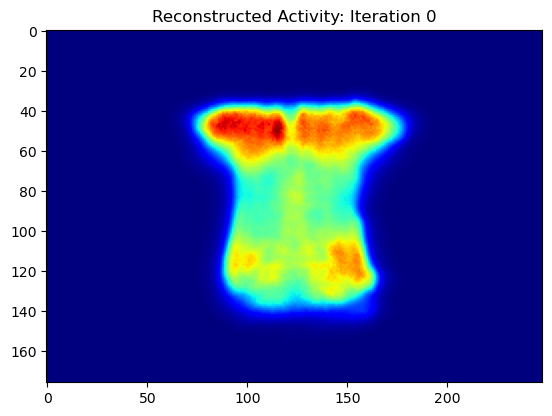

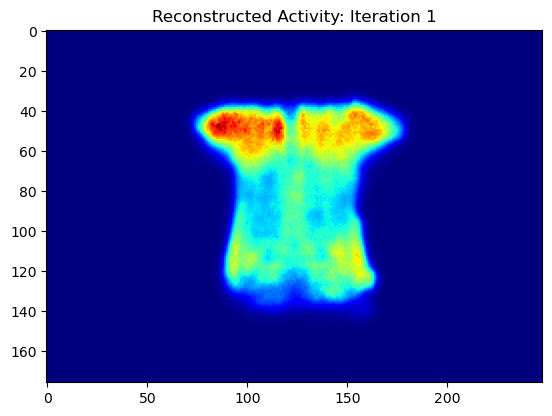

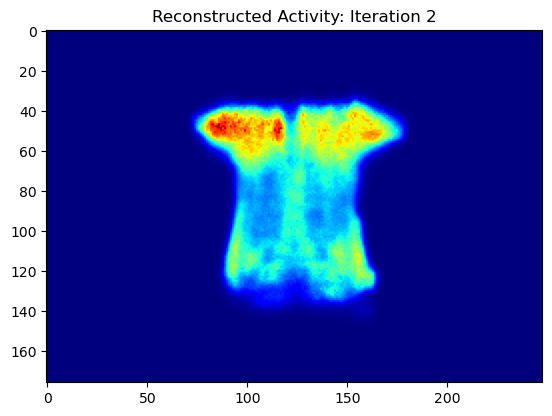

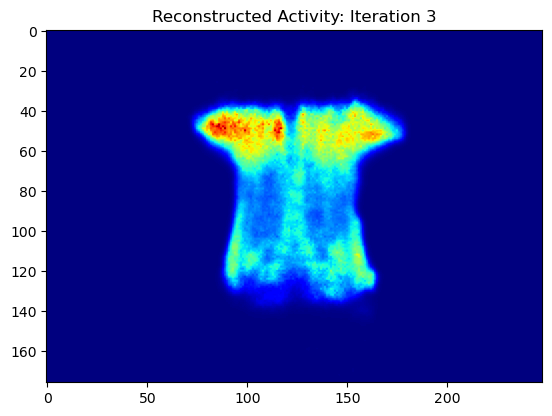

In [20]:
y_slice = activation.shape[1] // 2

plt.figure()
plt.imshow(activation_normalized[:, y_slice, :].T, cmap="jet")
plt.title("Clean Activity (activation)")

num_plots = 5

for iter in np.linspace(0, len(x_list) - 1, num_plots, dtype=int):
    x_normalized = (x_list[iter] - x_list[iter].min()) / (x_list[iter].max() - x_list[iter].min())
    plt.figure()
    plt.imshow(x_normalized[:, y_slice, :].T, cmap="jet")
    plt.title(f"Reconstructed Activity: Iteration {iter}")   

Best MSE at iteration 0 with value 0.964165210723877
Best SSIM at iteration 0 with value 0.00676513304751788
Best PSNR at iteration 0 with value 0.15848537907004356
Elbow point is at iteration 1 with metric value 0.9857767820358276
Elbow point is at iteration 2 with metric value 0.002305409800313178
Elbow point is at iteration 1 with metric value 0.062213619239628315


Text(0, 0.5, 'Metrics')

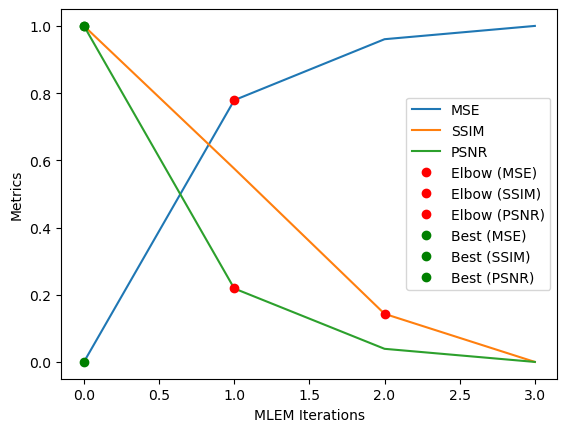

In [21]:
# Find elbow
from skimage.metrics import structural_similarity as ssim

def mse_loss(array1, array2):
    return np.mean((array1 - array2) ** 2)# Find elbow
def mae_loss(array1, array2):
    return np.mean(np.abs(array1 - array2))
def psnr_loss(array1, array2):
    mse = mse_loss(array1, array2)
    if mse == 0:
        return float('inf')
    max_pixel = array1.max()  # Adjust based on your image data range
    psnr = 20 * np.log10(max_pixel / np.sqrt(mse))
    return psnr

mse_loss_array = []
ssim_loss_array = []
psnr_loss_array = []


for i, x in enumerate(x_list):
    x_normalized = (x - x.min()) / (x.max() - x.min())
    mse_loss_array.append(mse_loss(x_normalized, activation_normalized))
    ssim_loss_array.append(ssim(x_normalized, activation_normalized, data_range=1.0))
    psnr_loss_array.append(psnr_loss(x_normalized, activation_normalized))

mse_loss_array = np.array(mse_loss_array)
ssim_loss_array = np.array(ssim_loss_array)
psnr_loss_array = np.array(psnr_loss_array)

# Print best metric iterations
best_mse = np.argmin(mse_loss_array)
print(f"Best MSE at iteration {best_mse} with value {mse_loss_array[best_mse]}")
best_ssim = np.argmax(ssim_loss_array)
print(f"Best SSIM at iteration {best_ssim} with value {ssim_loss_array[best_ssim]}")
best_psnr = np.argmax(psnr_loss_array)
print(f"Best PSNR at iteration {best_psnr} with value {psnr_loss_array[best_psnr]}")

# Print elbow 
# Function to calculate distance from a point to a line (given by two points)
def point_line_distance(point, line_start, line_end):
    return np.abs(np.cross(line_end-line_start, line_start-point)) / np.linalg.norm(line_end-line_start)
mlem_iterations = np.arange(len(x_list))
#MSE
# Coordinates of the first and last points
line_start = np.array([mlem_iterations[0], mse_loss_array[0]])
line_end = np.array([mlem_iterations[-1], mse_loss_array[-1]])
# Calculate distances from each point to the line
distances = np.array([point_line_distance(np.array([x,y]), line_start, line_end) for x, y in zip(mlem_iterations, mse_loss_array)])
# The index of the maximum distance point is the "elbow"
elbow_mse= np.argmax(distances)
print(f"Elbow point is at iteration {elbow_mse} with metric value {mse_loss_array[elbow_mse]}")
#SSIM
# Coordinates of the first and last points
line_start = np.array([mlem_iterations[0], ssim_loss_array[0]])
line_end = np.array([mlem_iterations[-1], ssim_loss_array[-1]])
# Calculate distances from each point to the line
distances = np.array([point_line_distance(np.array([x,y]), line_start, line_end) for x, y in zip(mlem_iterations, ssim_loss_array)])
# The index of the maximum distance point is the "elbow"
elbow_ssim= np.argmax(distances)
print(f"Elbow point is at iteration {elbow_ssim} with metric value {ssim_loss_array[elbow_ssim]}")
#PSNR
# Coordinates of the first and last points
line_start = np.array([mlem_iterations[0], psnr_loss_array[0]])
line_end = np.array([mlem_iterations[-1], psnr_loss_array[-1]])
# Calculate distances from each point to the line
distances = np.array([point_line_distance(np.array([x,y]), line_start, line_end) for x, y in zip(mlem_iterations, psnr_loss_array)])
# The index of the maximum distance point is the "elbow"
elbow_psnr= np.argmax(distances)
print(f"Elbow point is at iteration {elbow_psnr} with metric value {psnr_loss_array[elbow_psnr]}")

mse_loss_array = (mse_loss_array - mse_loss_array.min()) / (mse_loss_array.max() - mse_loss_array.min())
ssim_loss_array = (ssim_loss_array - ssim_loss_array.min()) / (ssim_loss_array.max() - ssim_loss_array.min())
psnr_loss_array = (psnr_loss_array - psnr_loss_array.min()) / (psnr_loss_array.max() - psnr_loss_array.min())

# Plot the metrics
plt.figure()
plt.plot(mlem_iterations, mse_loss_array, label="MSE")
plt.plot(mlem_iterations, ssim_loss_array, label="SSIM")
plt.plot(mlem_iterations, psnr_loss_array, label="PSNR")
# Plot the elbow
plt.plot(elbow_mse, mse_loss_array[elbow_mse], 'ro', label="Elbow (MSE)")
plt.plot(elbow_ssim, ssim_loss_array[elbow_ssim], 'ro', label="Elbow (SSIM)")
plt.plot(elbow_psnr, psnr_loss_array[elbow_psnr], 'ro', label="Elbow (PSNR)")
#Plot the best metrics
plt.plot(best_mse, mse_loss_array[best_mse], 'go', label="Best (MSE)")
plt.plot(best_ssim, ssim_loss_array[best_ssim], 'go', label="Best (SSIM)")
plt.plot(best_psnr, psnr_loss_array[best_psnr], 'go', label="Best (PSNR)")
plt.legend()
plt.xlabel("MLEM Iterations")
plt.ylabel("Metrics")